<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/multiseq/multiseq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!date

Tue Jul 13 00:24:18 UTC 2021


In [2]:
!git clone https://github.com/sbooeshaghi/BMGP_2020.git

Cloning into 'BMGP_2020'...
remote: Enumerating objects: 871, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 871 (delta 20), reused 0 (delta 0), pack-reused 817
Receiving objects: 100% (871/871), 472.32 MiB | 22.50 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (154/154), done.


In [3]:
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
  !pip install --quiet \
  kb-python==0.26.0 \
  anndata==0.7.6 \

     |████████████████████████████████| 59.1MB 48kB/s 
     |████████████████████████████████| 133kB 30.8MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 20.6MB 104kB/s 
     |████████████████████████████████| 2.0MB 37.0MB/s 
     |████████████████████████████████| 112kB 42.9MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 1.1MB 32.3MB/s 
     |████████████████████████████████| 71kB 5.0MB/s 


In [4]:
# extract everything
!ls /content/BMGP_2020/data/multiseq/kite_0/*.tar.gz |xargs -n1 tar -xf
!tar -xvf /content/BMGP_2020/data/multiseq/citeseqcount_0/umi_count.tar.gz

umi_count/
umi_count/features.tsv.gz
umi_count/matrix.mtx.gz
umi_count/matrix.T.mtx.gz
umi_count/barcodes.tsv.gz


In [5]:
!pip install --no-deps -i https://test.pypi.org/simple/ diffmx==0.0.5

Looking in indexes: https://test.pypi.org/simple/


# Imports

In [6]:
import anndata
from scipy.io import mmread, mmwrite
from kb_python.utils import import_matrix_as_anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from diffmx import plot, compare
from diffmx.utils import nd, yex

fsize = 18

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

colors = {
    "kb": "black",
    "cs": "red"
}

In [7]:
path = "/content/counts_unfiltered/adata.h5ad"
raw_kb = anndata.read_h5ad(path)

In [8]:
raw_kb

AnnData object with n_obs × n_vars = 636449 × 9
    var: 'feature_name'

In [9]:
mtx_path = "/content/umi_count/matrix.T.mtx.gz"
bcs_path = "/content/umi_count/barcodes.tsv.gz"
features_path = "/content/umi_count/features.tsv.gz"
t2g_path = "/content/BMGP_2020/references/multiseq/kite/f2b.txt"

raw_cs = import_matrix_as_anndata(mtx_path, bcs_path, features_path, t2g_path=t2g_path)
raw_cs.var.index = raw_cs.var.index.map(lambda x: x.split("-")[0])

In [10]:
filt_bcs_path = "/content/counts_filtered/cells_x_features.barcodes.txt"
filt_fea_path = "/content/counts_filtered/cells_x_features.genes.txt"

filtered_bcs = pd.read_csv(filt_bcs_path, header=None)
filtered_features = pd.read_csv(filt_fea_path, header=None)

In [11]:
common = np.intersect1d(np.intersect1d(raw_cs.obs.index.values, raw_kb.obs.index.values), nd(filtered_bcs.values))
common_features = np.intersect1d(filtered_features.values, raw_cs.var.index.values)

In [12]:
kb = raw_kb[raw_kb.obs.index.isin(common)][:,raw_kb.var.index.isin(common_features)]
cs = raw_cs[raw_cs.obs.index.isin(common)][:,raw_cs.var.index.isin(common_features)]

In [13]:
print(kb)
print(cs)

View of AnnData object with n_obs × n_vars = 11568 × 9
    var: 'feature_name'
View of AnnData object with n_obs × n_vars = 11568 × 9


In [14]:
print(False in (kb.obs.index.values == cs.obs.index.values))
print(False in (kb.var.index.values == cs.var.index.values))

True
False


In [15]:
kb = kb[kb.obs.sort_index().index]
cs = cs[cs.obs.sort_index().index]

kb = kb[:,kb.var.sort_index().index]
cs = cs[:,cs.var.sort_index().index]


In [16]:
print(True in (kb.obs.index.values != cs.obs.index.values))
print(True in (kb.var.index.values != cs.var.index.values))

False
False


In [17]:
kb.layers[0] = kb.X
kb.layers[1] = cs.X

kb.write_h5ad("multiseq.h5ad")

In [18]:
print(f"kb: {kb.layers[0].sum():,.0f}")
print(f"cs: {kb.layers[1].sum():,.0f}")

kb: 59,538,884
cs: 59,490,788


# Visualizations

## Knee

In [19]:
labels = ["kb", "cs"]
colors = ["#e41a1c", "#377eb8"]

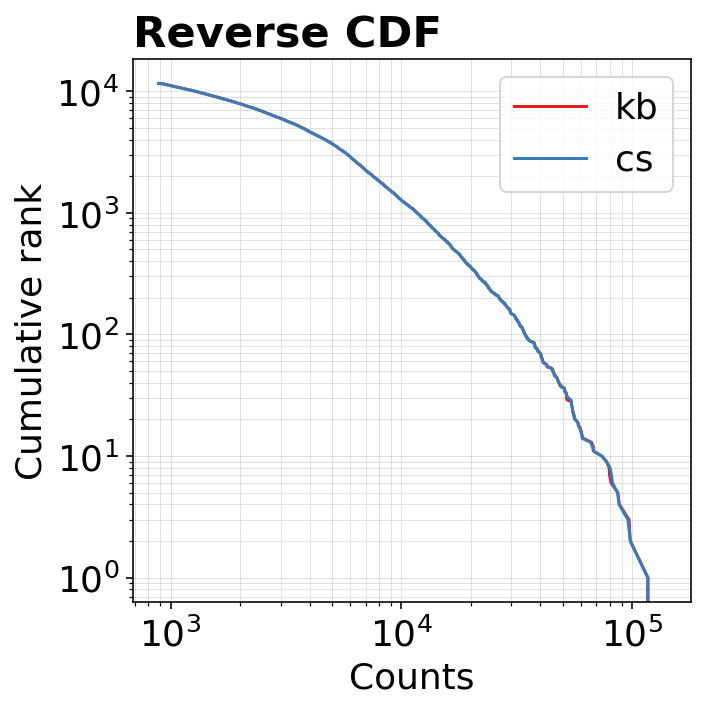

In [20]:
fig, ax = plt.subplots(figsize=(5,5))

x0,x1 = compare.rev_cdf(kb.X, cs.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors)

fig.show()

## pseudobulk

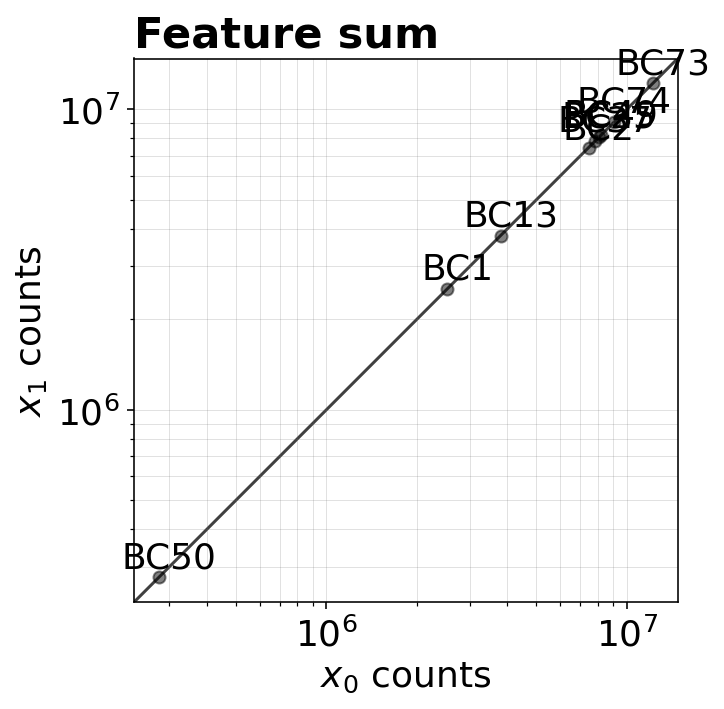

In [21]:
fig, ax = plt.subplots(figsize=(5,5))

x0, x1 = compare.cmp_sum(kb.X, cs.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5)

for (x,y,t) in zip(x0, x1, kb.var.index.values):
  ax.annotate(t, (x,y), ha="center", xycoords='data',
            xytext=(5, 5), textcoords='offset points',)

fig.show()

In [22]:
bc_map = {
"BC1": "GGAGAAGA",
"BC2": "CCACAATG",
"BC13": "CCAACCGG",
"BC25": "CGAAGCCC",
"BC37": "TCAGTCGA",
"BC49": "GACCAGCC",
"BC50": "CTCAAGGT",
"BC73": "CGCCGCAA",
"BC74": "ACCAGCCG",
}

In [23]:
# BC49
# bc:    GACCAGCC
# rc_bc: GGCTGGTC

# BC74
# bc:    ACCAGCCG
# rc_bc: CGGCTGGT

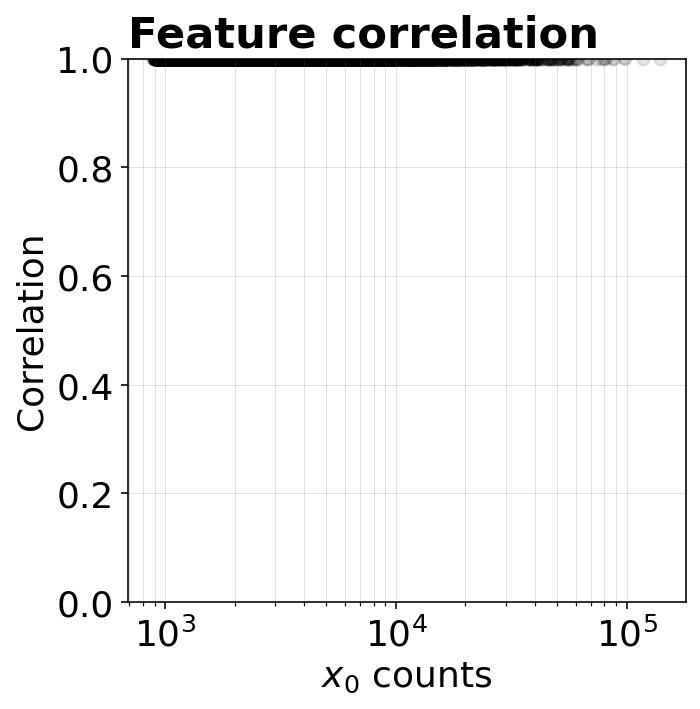

In [24]:
fig, ax = plt.subplots(figsize=(5,5))

x0, corr = compare.features_correlated(kb.X, cs.X)
plot.features_correlated(x0, corr, ax=ax)

fig.show()

### $l_1$ dist

In [25]:
XX_XY = compare.l1_distance(kb.X, cs.X)
YY_YX = compare.l1_distance(cs.X, kb.X)

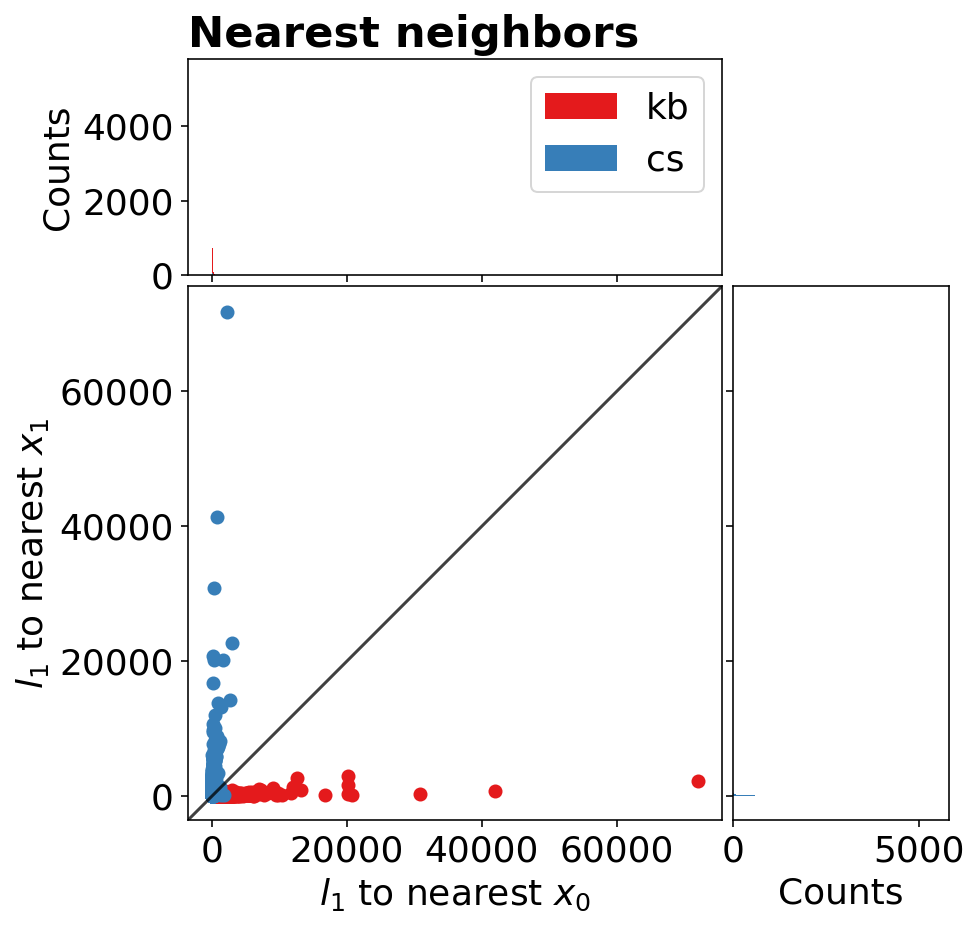

In [26]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                         ax=ax, 
                         labels=labels, 
                         colors=colors)

fig.show()

In [27]:
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

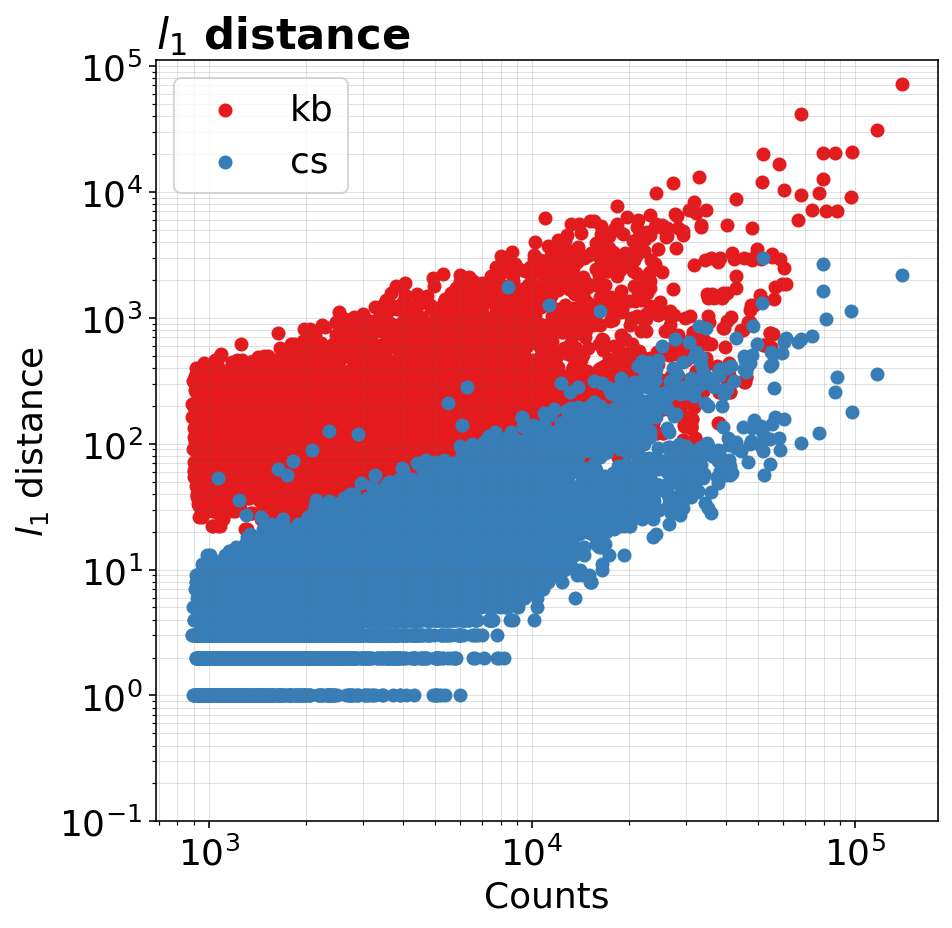

In [28]:
fig, ax = plt.subplots(figsize=(7,7))

plot.l1_counts((cnts, XX), (cnts, XY), 
               ax=ax, 
               colors=colors,
               labels=labels)
ax.set_ylim((0.1))

fig.show()

----------------------------------------

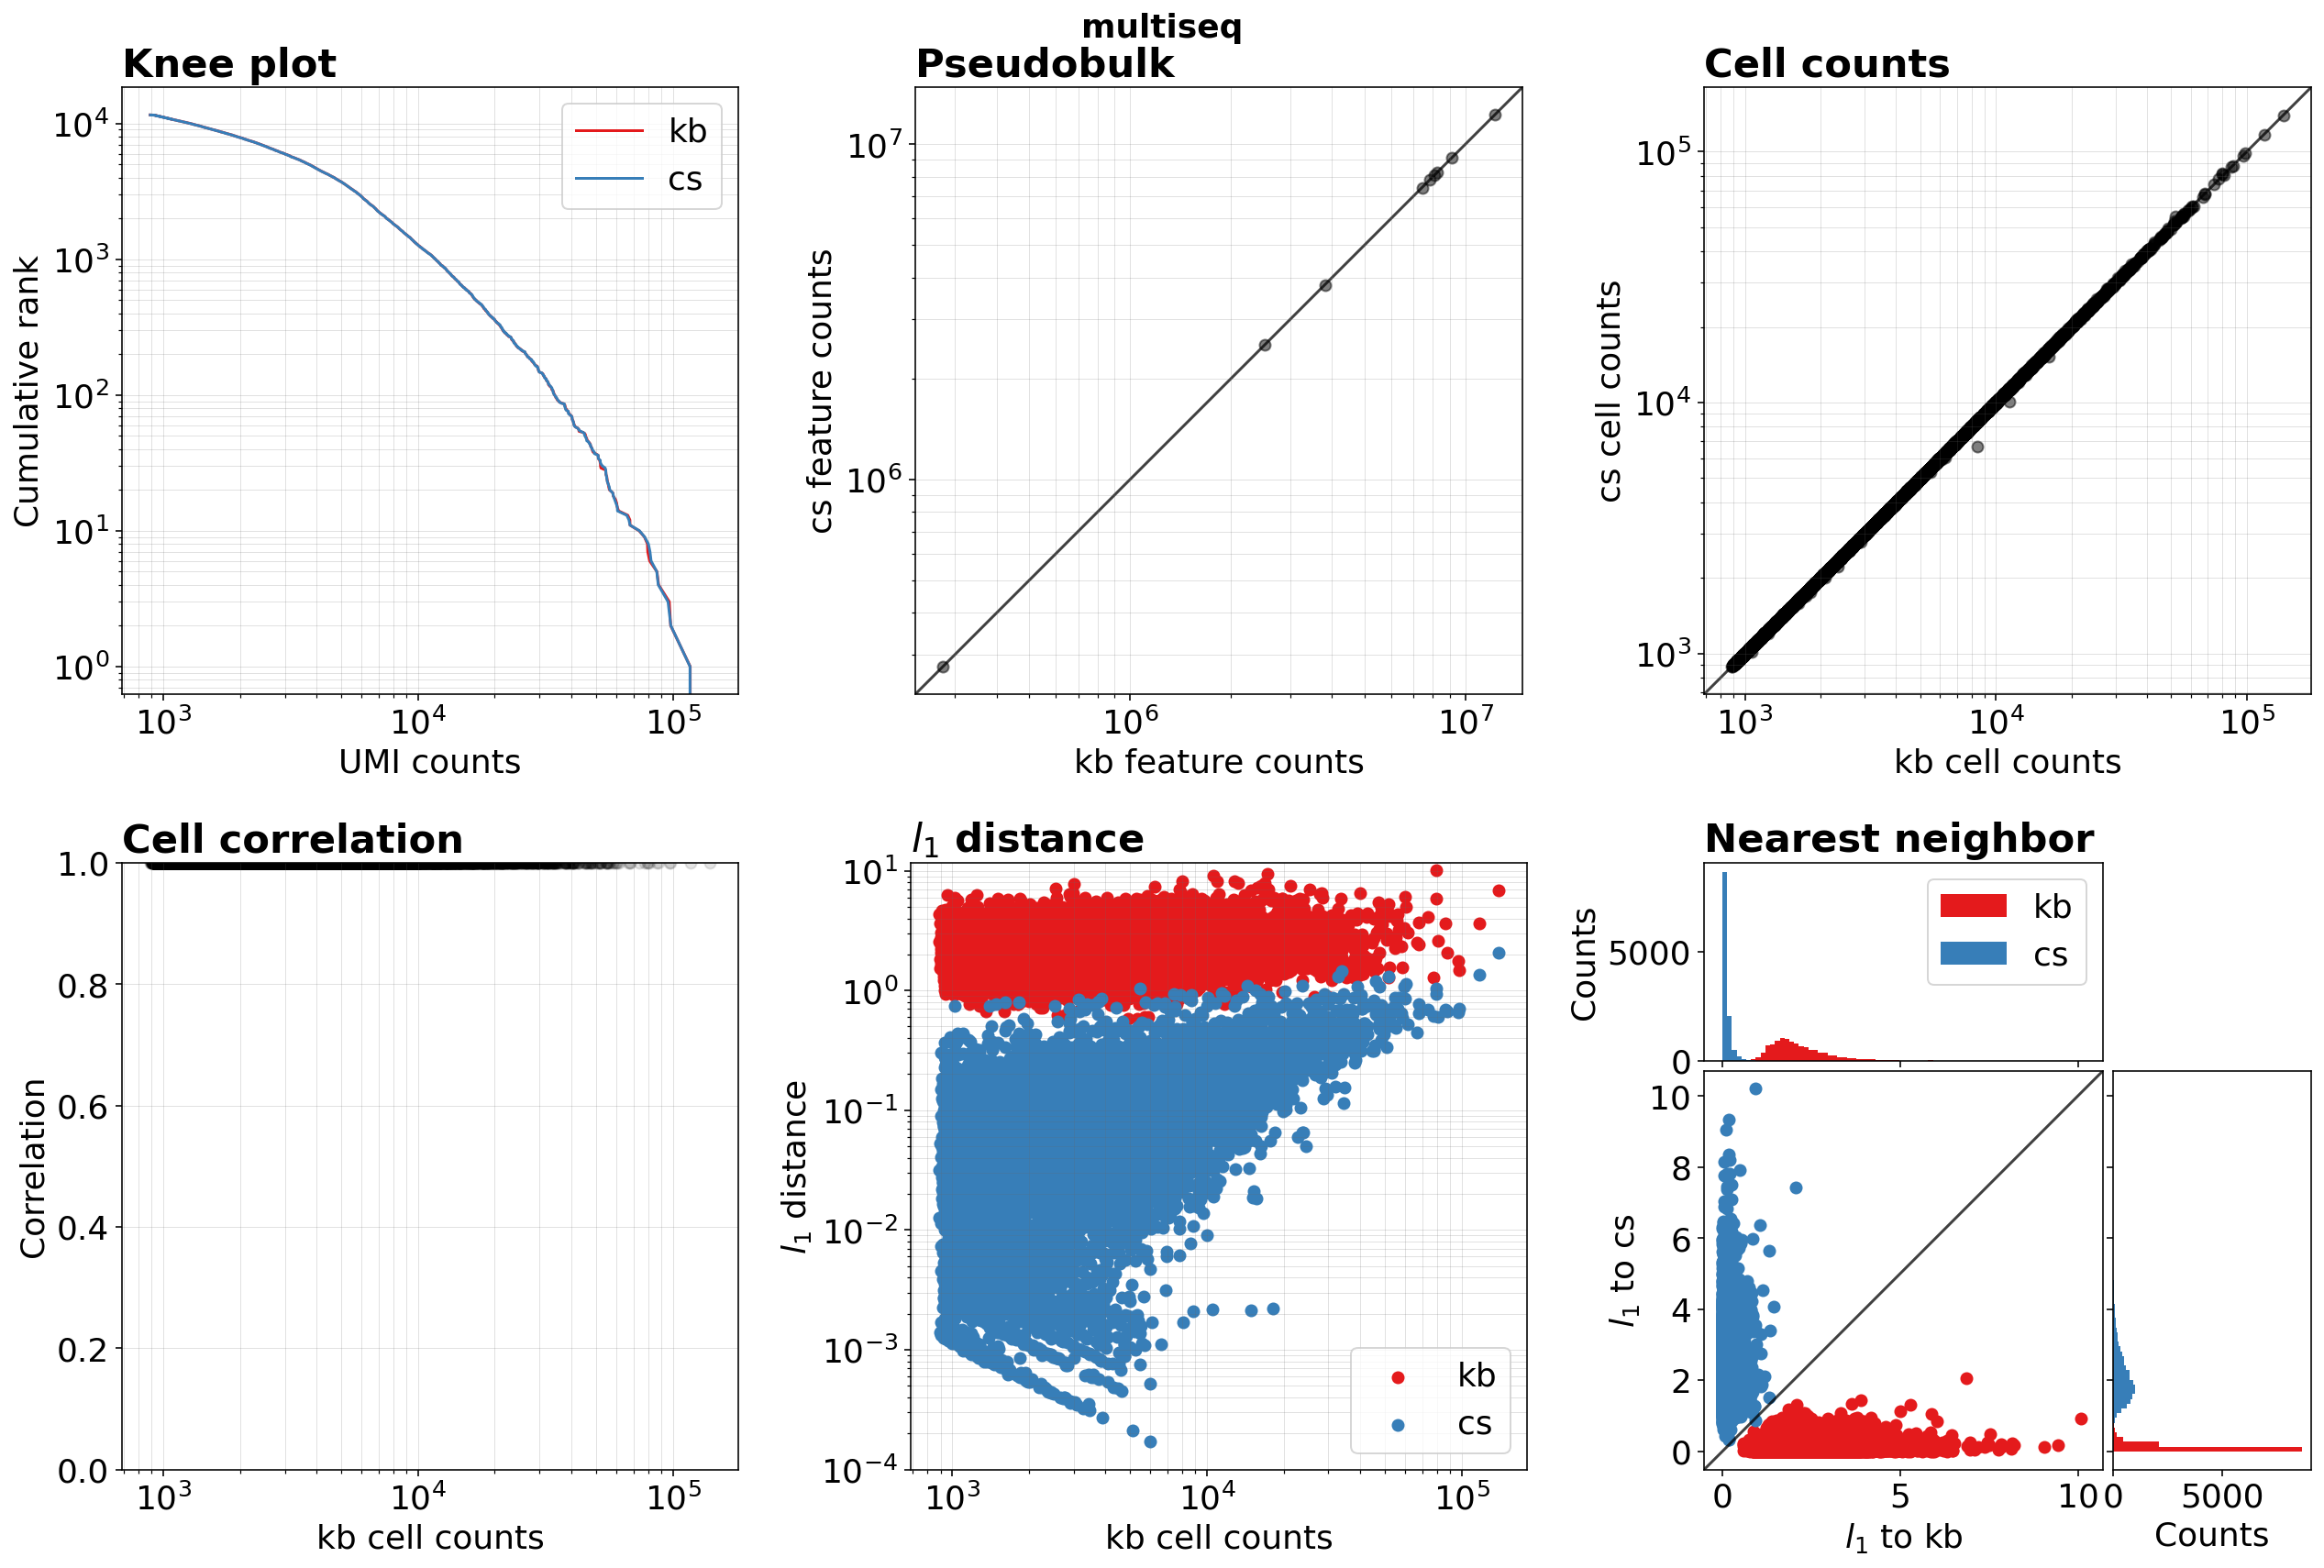

In [32]:
# Putting everything into one figure
row, col = (2, 3)
scale = 6

ds_name = "multiseq"

fig, axs = plt.subplots(figsize=(col*scale, row*scale), nrows=row, ncols=col)
fig.suptitle(ds_name, fontweight='bold', fontsize = fsize, x=0.5, y=0.999)

# knee plot
ax = axs[0,0]

title = "a"
x0,x1 = compare.rev_cdf(kb.X, cs.X, axis=1)
plot.rev_cdf(x0, x1, ax=ax, labels=labels, colors=colors, xlabel="UMI counts", title="Knee plot")


# pseudobulk
ax = axs[0,1]

title = "b"
x0, x1 = compare.cmp_sum(kb.X, cs.X)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} feature counts", ylabel=f"{labels[1]} feature counts", title="Pseudobulk")
# ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
# ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# cell counts
ax = axs[0,2]

title = "c"
x0, x1 = compare.cmp_sum(kb.X, cs.X, axis=1)
plot.cmp_sum(x0, x1, ax=ax, alpha=0.5, xscale="log", yscale="log", xlabel=f"{labels[0]} cell counts", ylabel=f"{labels[1]} cell counts", title="Cell counts")


# features correlated
ax = axs[1,0]

title = "d"
x0, corr = compare.features_correlated(kb.X, cs.X)
plot.features_correlated(x0, corr, ax=ax, xlabel=f"{labels[0]} cell counts", title="Cell correlation")

# l1 counts
ax = axs[1,1]

title = "e"
cnts = compare.sum_features(kb.X, axis=1)
XX, XY = XX_XY
YY, YX = YY_YX

plot.l1_counts((cnts, XX), (cnts, XY), 
   ax=ax, 
   colors=colors,
   labels=labels,
   xlabel=f"{labels[0]} cell counts")

ax.set_ylim(0.0001)

# nearest neighbor
ax = axs[1,2]

title = "f"
# note, taking log1p here
XX_XY = compare.l1_distance(np.log1p(kb.X), np.log1p(cs.X))
YY_YX = compare.l1_distance(np.log1p(cs.X), np.log1p(kb.X))
plot.l1_nearest_neighbor(XX_XY, YY_YX, 
                 ax=ax, 
                 labels=labels, 
                 colors=colors,
                 xlabel=f"$l_1$ to {labels[0]}",
                 ylabel=f"$l_1$ to {labels[1]}",
                 title="Nearest neighbor")

fig.tight_layout()
fig.savefig(f"{ds_name}.png", dpi=300, bbox_inches="tight")
fig.show()